In [1]:
from nsaba.nsaba import Nsaba
from nsaba.nsaba.visualizer import NsabaVisualizer
from nsaba.nsaba.geneinfo import gene_info
import pandas as pd
from scipy import stats
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture
plt.style.use('ggplot')
%matplotlib inline

/Users/simonhaxby/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Loading NS & ABA datafiles

data_dir = '../../data_dir/'
Nsaba.aba_load(data_dir)
Nsaba.ns_load(data_dir)

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.

This may take a minute or two ...
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.



In [3]:
# Intializing Nsaba object and loading gene expression

tnsaba = Nsaba()
tnsaba.load_ge_pickle('../../data_dir/Nsaba_ABA_ge.pkl')

This may take a minute or two ...
'ge' dictionary successfully loaded


In [4]:
tnsaba.is_term('reward')

True

In [5]:
# Setting term and Entrez IDs

term = 'reward'
gene = [1813]

In [6]:
# Generating estimated tf-idf coefficients

tnsaba.get_ns_act(term, thresh=-1)

This may take a few minutes...


This may take a minute or two ...


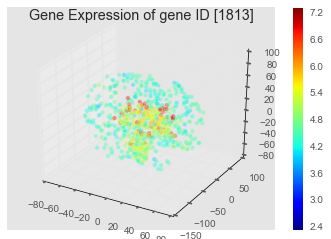

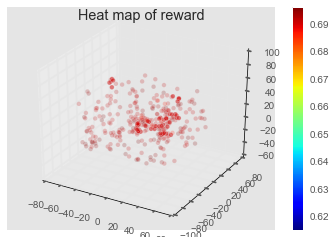

In [7]:
# Visualizing coefficient distribution

V = NsabaVisualizer(tnsaba)
V.visualize_ge(gene)
V.visualize_ns(term)

In [8]:
# Descriptive statistics of term and gene coefficients

analmat = tnsaba.make_ge_ns_mat(term, gene)
tsaba_df = pd.DataFrame(analmat)
tsaba_df.describe()

,0,1
count,878.000000,878.000000
mean,3.837122,0.010381
std,1.021049,0.022336
min,2.336206,0.000000
25%,3.088361,0.000000
50%,3.522295,0.000000
75%,4.331535,0.010801
max,7.341900,0.196514


In [9]:
%%time
# Hypothesis testing pre-processing
thres = .03

group1 = [row[0] for row in analmat if row[1] > thres]
group2 = [row[0] for row in analmat if row[1] <= thres]
len(group1)

CPU times: user 1.28 ms, sys: 2 µs, total: 1.29 ms
Wall time: 1.3 ms


In [10]:
%%time
# Clustering to determine control and functional coordinate groups

X = [[x] for x in analmat[:,1]]
kmn = KMeans(n_clusters=2, init=np.array([[min(analmat[:,1])], [max(analmat[:,1])]]))
bmat = kmn.fit_predict(X).astype(bool)
group1 = [row[0] for row in analmat if kmn.predict(row[1]) == 0]
group2 = [row[0] for row in analmat if kmn.predict(row[1]) == 1]
print min([len(group1), len(group2)])

76
CPU times: user 226 ms, sys: 5.17 ms, total: 231 ms
Wall time: 234 ms


/Users/simonhaxby/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:821: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  n_jobs=self.n_jobs)


In [12]:
gm = mixture.GMM(n_components=2)
gm.fit(X)
y = gm.predict(X)
group1 = [row[0] for row in analmat if gm.predict([[row[1]]]) == 0]
group2 = [row[0] for row in analmat if gm.predict([[row[1]]]) == 1]
print min([len(group1), len(group2)])

14


In [14]:
%%time
## Splitting groups based on masks
X = analmat[:,0]
print len(X)
cg = X[bmat]
print len(cg)
a = set(X)-set(cg)
print len(np.array(list(a)))

878
76
802
CPU times: user 581 µs, sys: 75 µs, total: 656 µs
Wall time: 593 µs


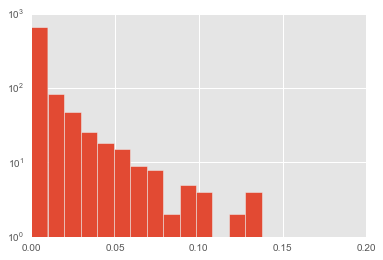

In [15]:
plt.hist(analmat[:,1], bins=20, log=True);

In [16]:
# Effect Size

def cohen_d(x1, x2, n1, n2):
    return (np.mean(x1) - np.mean(x2)) / np.sqrt( ((n1-1)*np.var(x1) + (n2-1)*np.var(x2)) / (n1 + n2 -2) )

In [17]:
# T-Test
lt_thres = max([group1, group2])
gt_thres = min([group1, group2])

print "t-value: %.4f \np-value: %.3E" % stats.ttest_ind(lt_thres, gt_thres)
print "Effect size: %.4f \n" % cohen_d(lt_thres, gt_thres, len(lt_thres),len(gt_thres))
# U-Test
print "Rank: %d \np-value: %.3E " % stats.mannwhitneyu(lt_thres, gt_thres)

t-value: -0.0534 
p-value: 9.574E-01
Effect size: -0.0144 

Rank: 5950 
p-value: 4.588E-01 


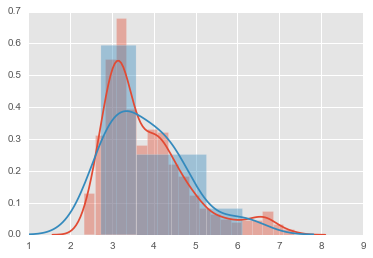

In [18]:
# Distributions of LT & GT thresholds

sns.distplot(gt_thres);
sns.distplot(lt_thres);

In [19]:
# Combining it all ...

def gene_term_ttest(gene, term, quant):
    analmat = tnsaba.make_ge_ns_mat(term, [gene])
    tsaba_df = pd.DataFrame(analmat)
    thres = tsaba_df.quantile(quant)[1]
    gt_thres = [row[0] for row in analmat if row[1] > thres]
    lt_thres = [row[0] for row in analmat if row[1] <= thres]
    # T-Test
    print "t-value: %.4f \np-value: %.3E" % stats.ttest_ind(lt_thres, gt_thres)
    print "Effect size: %.4f \n" % cohen_d(lt_thres,gt_thres,len(lt_thres),len(gt_thres))
    sns.distplot(gt_thres);
    sns.distplot(lt_thres);

t-value: -5.4645 
p-value: 6.054E-08
Effect size: -0.5167 



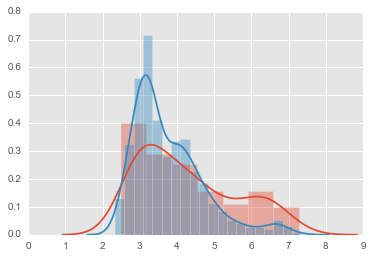

In [20]:
gene_term_ttest(1813, 'reward', .85)

In [ ]:
# Setting term
term_ = 'reward'
tnsaba.get_ns_act(term_, thresh=-1)

In [ ]:
# Finding smallest p-values across all Entrez IDs

## Parameters:
term = 'reward'
sample_num = len(tnsaba.ge.keys())
top_id_return = 25
thres = pd.DataFrame(tnsaba.term[term]['ns_act_vector']).quantile(.85)[0]
##

if len(tnsaba.ge) < sample_num:
    raise ValueError("Sample number exceeds stored number of Entrez IDs")
    
sam_ids = random.sample(tnsaba.ge.keys(), sample_num)
ge_mat = tnsaba.make_ge_ns_mat(term, sam_ids).T[:-1]
aba_sam_num = len(ge_mat[0])

gene_p = []
for eid, ge in zip(sam_ids, ge_mat):
    gt_thres = [ge[i] for i in xrange(aba_sam_num) if tnsaba.term[term]['ns_act_vector'][i] > thres]
    lt_thres = [ge[i] for i in xrange(aba_sam_num) if tnsaba.term[term]['ns_act_vector'][i] <= thres]
    test_stats = stats.ttest_ind(lt_thres, gt_thres)
    d = cohen_d(lt_thres, gt_thres, len(lt_thres), len(gt_thres))
    if test_stats[0] <= 0:
        gene_p.append( (eid, d, test_stats[1]) )
    else:
        continue

# Sorting from greatest magnitude of effect size
gene_p.sort(key=lambda ge: ge[1])

In [ ]:
%%time
# Using K-Means instead of variance cuts.

## Parameters:
term = 'reward'
sample_num = len(tnsaba.ge.keys())
top_id_return = 25
##

if len(tnsaba.ge) < sample_num:
    raise ValueError("Sample number exceeds stored number of Entrez IDs")
    
sam_ids = random.sample(tnsaba.ge.keys(), sample_num)
ge_mat = tnsaba.make_ge_ns_mat(term, sam_ids).T[:-1]
aba_sam_num = len(ge_mat[0])
kmn = KMeans(n_clusters=2)
X = [[x] for x in tnsaba.term[term]['ns_act_vector']]
Y = kmn.fit_predict(X)

gene_p = []
for eid, ge in zip(sam_ids, ge_mat):
    gt_thres = [ge[i] for i in xrange(aba_sam_num) if Y[i] == 1]
    lt_thres = [ge[i] for i in xrange(aba_sam_num) if Y[i] == 0]
    test_stats = stats.ttest_ind(lt_thres, gt_thres)
    d = cohen_d(lt_thres, gt_thres, len(lt_thres), len(gt_thres))
    if test_stats[0] <= 0:
        gene_p.append( (eid, d, test_stats[1]) )
    else:
        continue

# Sorting from greatest magnitude of effect size
gene_p.sort(key=lambda ge: ge[1])

In [ ]:
top_genes = []
for i in xrange(top_id_return):
    try:
        top_genes.append( (gene_p[i][0], gene_p[i][1], gene_p[i][2], gene_info(str(gene_p[i][0]))[0]) )
    except TypeError:
        continue
## Some ABA genes are not registered with NIH

In [ ]:
alpha = .05
print "Corrected Bonferoni Alpha: %.3E\n\n" % (alpha/float(sample_num))
for eid, coh_d, p_val, descr in top_genes:
    if len(descr) == 1:
        print "%d (p = %.3E; d = %.3f): < No description found >\n\n" % (eid, p_val, coh_d)    
    else:
        print "%d (p = %.3E; d = %.3f): %s\n\n" % (eid, p_val, coh_d, descr)

In [ ]:
# Visualizing p-value distribution
p_vals = [p[2] for p in gene_p ]
sig = sum([ p < .05/sample_num for p in p_vals])
print "Percent Significant (Bonferroni Correction; alpha = .05): %.3f %%" % (100*sig/float(sample_num))
sns.distplot(p_vals, norm_hist=False, bins=75, kde=False);

In [ ]:
# Log-scale Visualization of p-values
plt.hist(p_vals, bins=np.logspace(-13, -1, 20));
plt.xscale('log')

In [ ]:
# Visualizing effect-size distribution
p_vals = [p[1] for p in gene_p ]
sns.distplot(p_vals, norm_hist=False, bins=75, kde=False);
sns.rugplot([-0.5386], height=495);
# Green line DRD2 effect size

In [ ]:
p_less_than_d2 = sum([ p < 1.297E-08 for p in p_vals])
print " p-values less than DRD2 gene p-value: %.3f %%" % (100*p_less_than_d2/float(sample_num))